# Analýza VAERS dat
## Úvodem
**Toto není studie, ale pouze analýza dat bez jakéhokoli zaměření.**

Zdrojová data jsou veřejně dostupná, viz. [VAERS](https://vaers.hhs.gov/data/datasets.html).

Zdrojový kód zpracování dat je také veřejně dostupný, viz. [GitHub](https://github.com/fykcz/vaers.git).

Data jsou v souborech pro jednotlivé roky, evidence začíná rokem 1990. Název souboru je tvořen letopočtem a názvem dat: `YYYYVAERSDATA.csv`, resp. `YYYYVAERSVAX.csv`.
Popis struktur souborů a jejich obsahů je na stránce VAERS. Data v těchto souborech jsou svázána přes identifikátor `VAERS_ID`, kde primární data jsou v souboru `VAERSDATA`,
rozšiřující jsou v `VAERSVAX`.

Data nebyla konzultována z žádnou medicínskou autoritou, jedná se čistě o technické zpracování dat, jejich analýzu a vizualizaci s upozorněním na anomálie.


In [154]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import tabulate
from datetime import date

In [155]:
# nactu data z mezisouboru
bigdata = pd.read_feather('bigdata.feather')
disease_by_vax = pd.read_feather('disease_by_vax.feather')
vaxes = pd.read_feather('vaxes.feather')

In [156]:
def show_graph(inputData: pd.DataFrame, xaxis: str, yaxis: str, xlabel: str, ylabel: str, title: str):
    sns.set(palette = 'Blues_d')
    plt.figure(figsize=(15, 8))
    ax = sns.barplot(x = xaxis, y = yaxis, data = inputData)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.ylabel(ylabel, fontsize=15)
    plt.xlabel(xlabel, fontsize=15)
    plt.title(title, fontsize=20)
    plt.show()

## Rychlá analýza dat
### Data bez COVID19 záznamů
Proberu narychlo data přes typy vakcín. Proberu všechny záznamy pro jednotlivé typy vakcín. V tomto grafu nebudu brát data za COVID19 a neznámé vakcíny. Zároveň ignoruju typy vakcín, u nichž je počet záznamů menší než 10000. Prostě jsem si řekl, že méně problémové typy vakcín nebudu brát na zřetel. To ovšem neznamená, že nemají problém. Jen jsem se rozhodl pro tuto práci je ignorovat. A nastavil jsem hranici na 10000 případů. 10000 případů od roku 1990, kdy se začaly hlásit případy do systému VAERS.

In [157]:
# pocet pripadu na jednotlivy typ vakciny
# odfiltruji COVID19, UNK (unknown) typy a pak vsechny typy, kde je vyskyt mensi nez 1000
vaxcounts = vaxes[['VAX_TYPE', 'VAERS_ID']].groupby('VAX_TYPE').agg('count').reset_index().sort_values('VAX_TYPE')
filtr = (
            (vaxcounts['VAX_TYPE'] != 'COVID19') &
            (vaxcounts['VAX_TYPE'] != 'UNK') &
            (vaxcounts['VAERS_ID'] >= 10000)
        )
vaxcounts_forgraph = vaxcounts[filtr].sort_values('VAERS_ID', ascending=False)

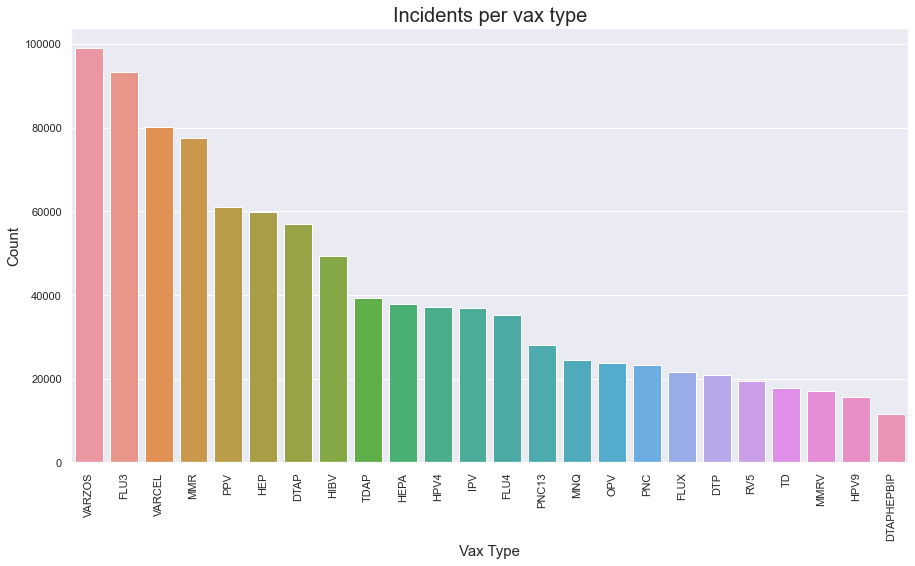

In [158]:
show_graph(inputData=vaxcounts_forgraph,
           xaxis='VAX_TYPE',
           yaxis='VAERS_ID',
           xlabel='Vax Type',
           ylabel='Count',
           title='Incidents per vax type')

Zůstalo nám tady pár typů vakcín, které stojí za prozkoumání.

In [159]:
vaxdesc_full = pd.read_excel('vax_type_description.xlsx')
vaxdesc = vaxdesc_full[vaxdesc_full['VAX_TYPE'].isin(vaxcounts_forgraph['VAX_TYPE'].tolist())]
vaxdesctable = vaxcounts_forgraph.merge(vaxdesc, left_on='VAX_TYPE', right_on='VAX_TYPE').rename(columns={'VAERS_ID':'COUNT'})

In [160]:
ndata = bigdata[bigdata['VAX_TYPE'].isin(vaxcounts_forgraph['VAX_TYPE'].tolist())]
gndata = ndata.groupby('VAX_TYPE').agg(['count', 'min'])
gn = gndata.loc[:, [('VAERS_ID', 'count'), ('RECVDATE', 'min')]].sort_values('VAX_TYPE').reset_index()
gn.columns = gn.columns.to_flat_index()
gn.rename(columns={gn.columns[0]:'VAX_TYPE', gn.columns[1]:'COUNT', gn.columns[2]:'RECVDATE'}, inplace=True)

In [161]:
vx = vaxdesctable.merge(gn, left_on='VAX_TYPE', right_on='VAX_TYPE')[['VAX_TYPE', 'COUNT_x', 'DESCRIPTION', 'RECVDATE']].rename(columns={'COUNT_x':'COUNT'})
vx['MINDATE'] = vx['RECVDATE'].dt.strftime('%d.%m.%Y')

Ještě si doplním data k zobrazenému grafu. Ve sloupečku `COUNT` je hodnota, co je v grafu, ve sloupečku `MINDATE` je datum prvního záznamu v systému VAERS ke konkrétnímu typu vakcíny a `DESCRIPTION` je potom textový popis vakcíny.

In [162]:
cols = ['VAX_TYPE', 'COUNT', 'MINDATE', 'DESCRIPTION']
xx = tabulate.tabulate(vx[cols], tablefmt='html', headers = cols, showindex="never")
display(xx)


VAX_TYPE,COUNT,MINDATE,DESCRIPTION
VARZOS,98940,17.07.2006,Varicella-zoster vaccine
FLU3,93354,09.07.1990,"Influenza virus vaccine, trivalent"
VARCEL,80189,23.05.1995,Varivax-varicella virus live
MMR,77536,02.07.1990,"Measles, mumps and rubella virus vaccine, live"
PPV,61006,09.07.1990,"Pneumococcal vaccine, polyvalent"
HEP,59783,09.07.1990,Hepatitis B virus vaccine
DTAP,56929,07.04.1992,Diphtheria and tetanus toxoids and acellular pertussis vaccine
HIBV,49310,09.07.1990,Haemophilus B conjugate vaccine
TDAP,39223,28.06.2005,"Tetanus toxoid, reduced diphtheria toxoid and acellular pertussis vaccine, adsorbed"
HEPA,37823,24.04.1995,Hepatitis A


Podle počtu incidentů je tedy rozhodně "zajímavý" typ VARZOS, tedy Varicella-zoster vakcína. Půjčil jsem si popis k Varicella-zoster onemocnění:

*Virus varicella zoster patřící do skupiny herpetických virů je při primoinfekci vyvolavatelem planých neštovic, při jeho reaktivaci člověk onemocní pásovým oparem.*

To bychom měli data bez COVID19 záznamů. Tyto jsem záměrně v této první fázi odfiltroval, neboť mi poněkud dramaticky narušovaly analýzu zbylých dat.

### Data s COVID19 záznamy
Teď udělám to samé, jen nebudu filtrovat COVID19 záznamy.

In [163]:
# pocet pripadu na jednotlivy typ vakciny
# odfiltruji UNK (unknown) typy a pak vsechny typy, kde je vyskyt mensi nez 10000
vaxcounts = vaxes[['VAX_TYPE', 'VAERS_ID']].groupby('VAX_TYPE').agg('count').reset_index().sort_values('VAX_TYPE')
filtr = (
            (vaxcounts['VAX_TYPE'] != 'UNK') &
            (vaxcounts['VAERS_ID'] >= 10000)
        )
vaxcounts_forgraph = vaxcounts[filtr].sort_values('VAERS_ID', ascending=False)


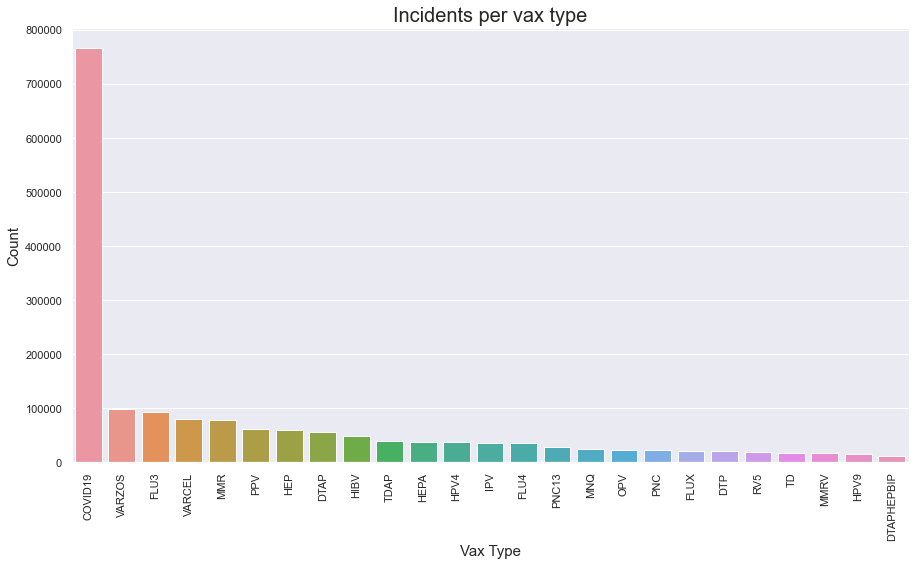

In [164]:
show_graph(inputData=vaxcounts_forgraph,
           xaxis='VAX_TYPE',
           yaxis='VAERS_ID',
           xlabel='Vax Type',
           ylabel='Count',
           title='Incidents per vax type')

Data se celkem dramaticky změnila.

In [165]:
ndata = bigdata[bigdata['VAX_TYPE'].isin(vaxcounts_forgraph['VAX_TYPE'].tolist())]
gndata = ndata.groupby('VAX_TYPE').agg(['count', 'min'])
gn = gndata.loc[:, [('VAERS_ID', 'count'), ('RECVDATE', 'min')]].sort_values('VAX_TYPE').reset_index()
gn.columns = gn.columns.to_flat_index()
gn.rename(columns={gn.columns[0]:'VAX_TYPE', gn.columns[1]:'COUNT', gn.columns[2]:'RECVDATE'}, inplace=True)

In [166]:
vaxdesc = vaxdesc_full[vaxdesc_full['VAX_TYPE'].isin(vaxcounts_forgraph['VAX_TYPE'].tolist())]
vaxdesctable = vaxcounts_forgraph.merge(vaxdesc, left_on='VAX_TYPE', right_on='VAX_TYPE').rename(columns={'VAERS_ID':'COUNT'})
vx = vaxdesctable.merge(gn, left_on='VAX_TYPE', right_on='VAX_TYPE')[['VAX_TYPE', 'COUNT_x', 'DESCRIPTION', 'RECVDATE']].rename(columns={'COUNT_x':'COUNT'})
vx['MINDATE'] = vx['RECVDATE'].dt.strftime('%d.%m.%Y')

Stejně jako předtím, zobrazím si data.

In [167]:
cols = ['VAX_TYPE', 'COUNT', 'MINDATE', 'DESCRIPTION']
xx = tabulate.tabulate(vx[cols], tablefmt='html', headers = cols, showindex="never")
display(xx)


VAX_TYPE,COUNT,MINDATE,DESCRIPTION
COVID19,765740,15.12.2020,Coronavirus 2019 vaccine
VARZOS,98940,17.07.2006,Varicella-zoster vaccine
FLU3,93354,09.07.1990,"Influenza virus vaccine, trivalent"
VARCEL,80189,23.05.1995,Varivax-varicella virus live
MMR,77536,02.07.1990,"Measles, mumps and rubella virus vaccine, live"
PPV,61006,09.07.1990,"Pneumococcal vaccine, polyvalent"
HEP,59783,09.07.1990,Hepatitis B virus vaccine
DTAP,56929,07.04.1992,Diphtheria and tetanus toxoids and acellular pertussis vaccine
HIBV,49310,09.07.1990,Haemophilus B conjugate vaccine
TDAP,39223,28.06.2005,"Tetanus toxoid, reduced diphtheria toxoid and acellular pertussis vaccine, adsorbed"


Zůstanu u dat s COVID19. Doplním počet měsíců od prvního záznamu k dnešnímu dni a spočítám, kolik hlášení chodí průměrně ke každému typu vakcíny.

In [168]:
actual_date = date.today()
vx['MONTHS'] = (actual_date.year - pd.DatetimeIndex(vx['RECVDATE']).year) * 12 + (actual_date.month - pd.DatetimeIndex(vx['RECVDATE']).month)
vx['AVGPERMONTH'] = round(vx['COUNT'] / vx['MONTHS'], 1)
vx.sort_values('AVGPERMONTH', ascending=False, inplace=True)

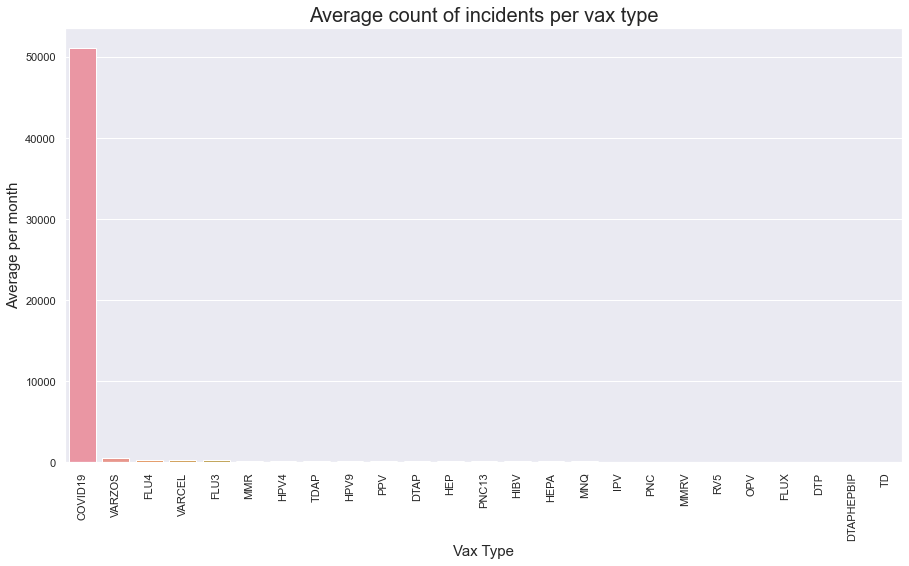

In [169]:

show_graph(inputData=vx,
           xaxis='VAX_TYPE',
           yaxis='AVGPERMONTH',
           xlabel='Vax Type',
           ylabel='Average per month',
           title='Average count of incidents per vax type')

Zase si k tomu zobrazím data.

In [170]:
cols = ['VAX_TYPE', 'AVGPERMONTH', 'DESCRIPTION']
xx = tabulate.tabulate(vx[cols], tablefmt='html', headers = cols, showindex="never")
display(xx)

VAX_TYPE,AVGPERMONTH,DESCRIPTION
COVID19,51049.3,Coronavirus 2019 vaccine
VARZOS,526.3,Varicella-zoster vaccine
FLU4,345.6,"Influenza virus vaccine, quadrivalent"
VARCEL,249,Varivax-varicella virus live
FLU3,245.7,"Influenza virus vaccine, trivalent"
MMR,204,"Measles, mumps and rubella virus vaccine, live"
HPV4,197.1,Human papillomavirus quadrivalent
TDAP,195.1,"Tetanus toxoid, reduced diphtheria toxoid and acellular pertussis vaccine, adsorbed"
HPV9,181.5,Human papillomavirus 9-valent
PPV,160.5,"Pneumococcal vaccine, polyvalent"


Protože nám data pro COVID19 zase dramaticky rozsekaly graf, tak ještě jednou bez nich.

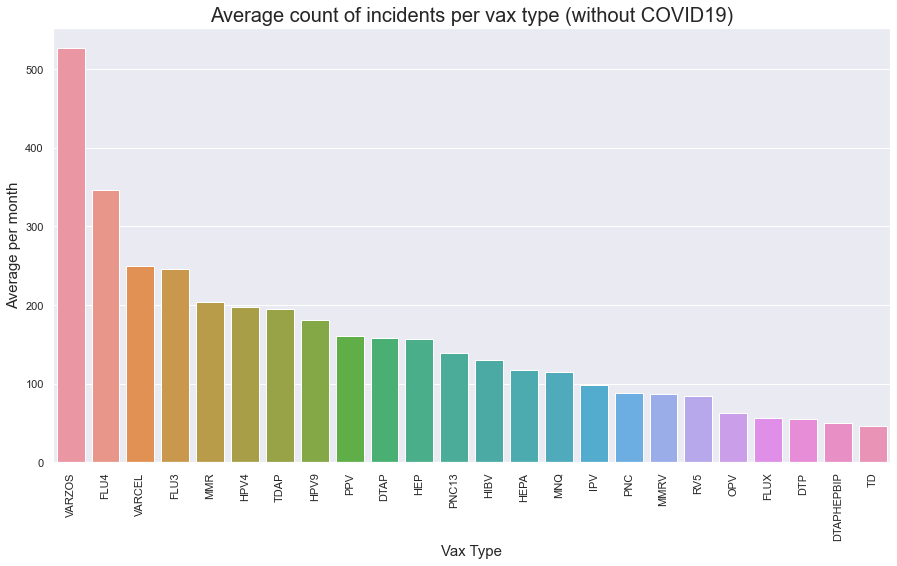

In [171]:
vx = vx[vx['VAX_TYPE'] != 'COVID19']

show_graph(inputData=vx,
           xaxis='VAX_TYPE',
           yaxis='AVGPERMONTH',
           xlabel='Vax Type',
           ylabel='Average per month',
           title='Average count of incidents per vax type (without COVID19)')